In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [6]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)

In [7]:
from sklearn.model_selection import train_test_split, KFold

In [8]:
n_splits = 10


In [9]:
from common import compute_rmse

In [10]:
np.arange(0.1, 1.0, 0.1)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [11]:
H_au, A_au, T_au = learn_HAT(case, au_tensor, 2, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
H, A, T = learn_HAT(case, tensor, 2, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_au)
H_n, A_n, T_n = learn_HAT(case, tensor, 2, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost)

H_se, A_se, T_se ={}, {}, {}
for constant in [0.1, 1, 10]:
    h, A_c, t = learn_HAT(case, au_tensor, 2, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=constant*np.ones(12).reshape(-1, 1))

    H_se[constant], A_se[constant], T_se[constant] = learn_HAT(case, tensor, 2, 3, num_iter=2000, lr=0.1, dis=False, cost_function=cost,
                    A_known=A_c, T_known=constant*np.ones(12).reshape(-1, 1))

In [12]:
HAT = multiply_case(H, A, T, case)
HAT_n = multiply_case(H_n, A_n, T_n, case)

HAT_se = {}
for constant in [0.1, 1, 10]:
    HAT_se[constant] = multiply_case(H_se[constant], A_se[constant], T_se[constant], case)

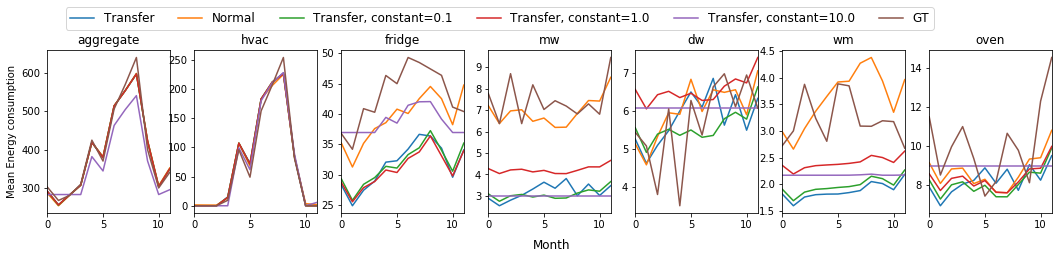

In [13]:
fig, ax = plt.subplots(ncols=7, figsize=(18, 3), sharex=True)
for i, appliance in enumerate(APPLIANCES_ORDER):
    pred_appliance= pd.DataFrame(HAT[:, APPLIANCES_ORDER.index(appliance), :], index=df.index).mean()
    pred_appliance.plot(ax=ax[i], label='Transfer')
    pred_normal = pd.DataFrame(HAT_n[:, APPLIANCES_ORDER.index(appliance), :], index=df.index).mean()
    pred_normal.plot(ax=ax[i], label='Normal')
    for constant in [0.1, 1, 10]:
        pred_appliance_season= pd.DataFrame(HAT_se[constant][:, APPLIANCES_ORDER.index(appliance), :], index=df.index).mean()
        pred_appliance_season.plot(ax=ax[i], label='Transfer, constant=%0.1f' %constant)
    gt_appliance = df[['%s_%d' %(appliance, month) for month in range(1, 13)]].mean()
    gt_appliance.index =pred_appliance.index
    gt_appliance.plot(ax=ax[i], label='GT')
    ax[i].set_title(appliance)
ax[0].legend( bbox_to_anchor=(0.1,1.3), loc="upper left", ncol=6, fontsize=12)
ax[0].set_ylabel("Mean Energy consumption")
fig.text(0.5, -0.04, "Month", fontsize=12)